In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import plotly.graph_objects as go
import plotly.express as px


In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

### Download Data

In [4]:

# fname = "hcp_task.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/s4h8j/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

### Regions

In [5]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [6]:
df_regions = pd.DataFrame(regions)

In [7]:
df_regions.to_csv('regions.csv')

In [8]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [9]:
arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lag = 2
xs = []
ys=[]
for i in range(len(arr) - lag):
    xs.append(arr[i:i+lag])
    ys.append(arr[i+lag:i+lag+1])
xs

[[1, 2],
 [2, 3],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15]]

In [10]:
ys

[[3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16]]

In [11]:
arrayx = np.array(xs)
arrayx.shape

(14, 2)

In [12]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1

evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
evs[0][1]

array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171])

In [13]:
def average_frames_win( data , evs, experiment, cond):    
            idx = EXPERIMENTS[experiment]['cond'].index(cond)
            ts_i = np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)
            return ts_i

In [14]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

def makeWinDataForAllSubjects():
    NumberofSubjects = 339
    subjects = range(NumberofSubjects)
    tsAll = np.array([])
    conditionWin = 'win'
    my_exp  = 'GAMBLING'
    my_subj = 0
    my_run  = 1
    
        
    for i in subjects:
        data = load_single_timeseries(subject=i, experiment=my_exp,run=my_run,remove_mean=True)
        evs = load_evs(subject=i, experiment=my_exp,run=my_run)
        tsi = average_frames_win(data, evs, my_exp , cond=conditionWin)
        tsAll = np.concatenate((tsAll, tsi))
    return tsAll

        
tsWinData = makeWinDataForAllSubjects()

In [15]:
tsWinData = tsWinData.reshape(339,-1)
tsWinData.shape

(339, 360)

In [16]:
def makelossDataForAllSubjects():
    NumberofSubjects = 339
    subjects = range(NumberofSubjects)
    tsAll = np.array([])
    conditionloss = 'loss'
    my_exp  = 'GAMBLING'
    my_subj = 0
    my_run  = 1
    
        
    for i in subjects:
        data = load_single_timeseries(subject=i, experiment=my_exp,run=my_run,remove_mean=True)
        evs = load_evs(subject=i, experiment=my_exp,run=my_run)
        tsi = average_frames_win(data, evs, my_exp , cond=conditionloss)
        tsAll = np.concatenate((tsAll, tsi))
    return tsAll

        
tslossData = makelossDataForAllSubjects()

In [17]:
tslossData = tslossData.reshape(339,-1)
tslossData.shape

(339, 360)

In [18]:
#win = 1
# loss = 0
NumberofSubjects = 339
#make array of output values Y.
one= np.ones(NumberofSubjects)
zero = np.zeros(NumberofSubjects)

In [19]:
y = np.concatenate((one,zero))
len(y) == 339*2

True

In [20]:
X = np.concatenate((tsWinData, tslossData))
X.shape

(678, 360)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f'X_train shape is {X_train.shape}\nX_test shape is {X_test.shape} \ny_train shape is {y_train.shape} \ny_test shape is {y_test.shape}')

X_train shape is (508, 360)
X_test shape is (170, 360) 
y_train shape is (508,) 
y_test shape is (170,)


In [22]:
np.save('XbrainRegions.npy', X)
np.save('YbrainRegions.npy', y)

In [23]:
scaler_X = StandardScaler()
f_transformer = scaler_X.fit(X_train)

X_train = f_transformer.transform(X_train)
X_test = f_transformer.transform(X_test)


In [24]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [25]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.9352941176470588


In [26]:
predictions = logisticRegr.predict(X_test)
ConfusionMatrix = metrics.confusion_matrix(y_test, predictions)
print(ConfusionMatrix)

[[84  9]
 [ 2 75]]


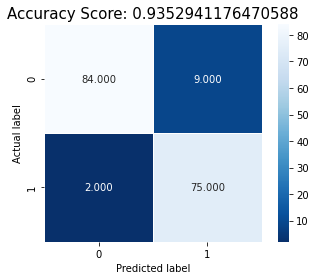

In [27]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

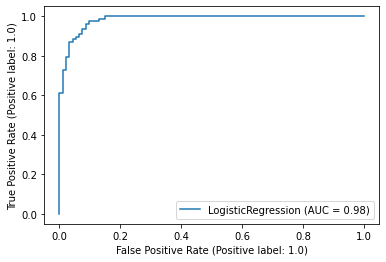

In [28]:
from sklearn import metrics
metrics.plot_roc_curve(logisticRegr , X_test, y_test)
plt.show()

In [29]:
#example of turning data to sequential.
arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lag = 2
xs = []
ys=[]
for i in range(len(arr) - lag):
    xs.append(arr[i:i+lag])
    ys.append(arr[i+lag:i+lag+1])
xs

[[1, 2],
 [2, 3],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15]]

In [30]:
X.shape

(678, 360)

In [31]:
array_length = 678*360

In [32]:
X_timeSeries = X.reshape(array_length)
X_timeSeries.shape[0] == array_length

True

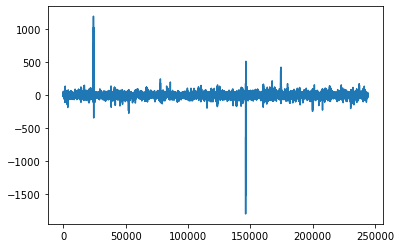

In [43]:
plt.plot(X_timeSeries)

In [34]:
lag = 24

Xs = []
ys = []

for i in range(len(X_timeSeries) - lag):
    Xs.append(X_timeSeries[i:i+lag])
    ys.append(X_timeSeries[i+lag:i+lag+1])

Xs = np.array(Xs)
ys = np.array(ys)

print(f'Xs shape {Xs.shape}\nYs shape {ys.shape}')

Xs shape (244056, 24)
Ys shape (244056, 1)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=0)
print(f'X_train shape is {X_train.shape}\nX_test shape is {X_test.shape} \ny_train shape is {y_train.shape} \ny_test shape is {y_test.shape}')

X_train shape is (183042, 24)
X_test shape is (61014, 24) 
y_train shape is (183042, 1) 
y_test shape is (61014, 1)


In [36]:
def get_models(models=dict()):
    models['DecisionTreeRegressor'] = DecisionTreeRegressor()
    models['LinearRegression'] = LinearRegression()
    return models

In [37]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

feature_transformer = scaler_X.fit(X_train)
target_trasformer = scaler_y.fit(y_train)


X_train = feature_transformer.transform(X_train)
X_test = feature_transformer.transform(X_test)
y_train = target_trasformer.transform(y_train)
y_test = target_trasformer.transform(y_test)


In [38]:
def evaluate_models(models, Xtrain, yTrain, Xtest , yTest):
    mae = dict()
    for name, model in models.items():
        regressor = model
        regressor.fit(Xtrain, yTrain)
        y_pred = regressor.predict(Xtest)
        y_pred = target_trasformer.inverse_transform(y_pred)
        y_real = target_trasformer.inverse_transform(yTest)

        plt.plot(y_real[50:100],marker='.', label="true")
        plt.plot(y_pred[50:100],'r', label="prediction")
        plt.title(name)
        plt.legend()
        plt.show()
        maeModel = mean_absolute_error(y_real,y_pred)
        mae[f'{name}'] = (maeModel)
    return mae

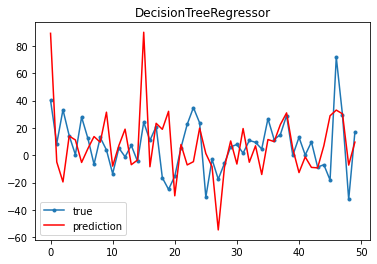

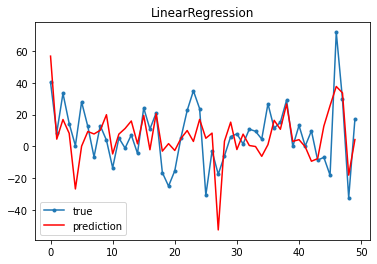

{'DecisionTreeRegressor': 16.77301747436334,
 'LinearRegression': 11.562531543736275}

In [39]:
models = get_models()
evaluate_models(models, X_train, y_train,X_test,y_test)

## Classification with PCA

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

y = y
sc = StandardScaler()

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

pca = PCA(n_components=56)
pca.fit(X_scaled) 
X_pca = pca.transform(X_scaled) 

# FIT the pca on train only!
X_pca.shape

(678, 56)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=0)
print(f'X_train shape is {X_train.shape}\nX_test shape is {X_test.shape} \ny_train shape is {y_train.shape} \ny_test shape is {y_test.shape}')

X_train shape is (508, 56)
X_test shape is (170, 56) 
y_train shape is (508,) 
y_test shape is (170,)


In [40]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9


In [41]:
predictions = logisticRegr.predict(X_test)
ConfusionMatrix = metrics.confusion_matrix(y_test, predictions)
print(ConfusionMatrix)

[[81 12]
 [ 5 72]]


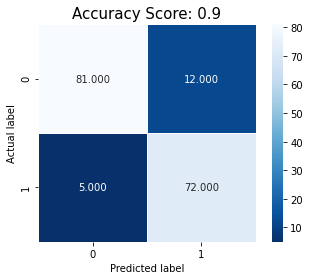

In [42]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [43]:

explained_variance = pca.explained_variance_ratio_

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])


df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
# df_explained_variance = df_explained_variance.drop(['PC'] , axis =1)
# df_explained_variance.head()

<BarContainer object of 57 artists>

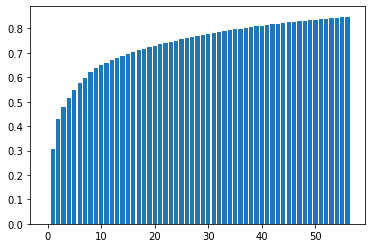

In [48]:
l = []
for i in range(57):
    l.append(i)
    
plt.bar(l , df_explained_variance['Cumulative Variance'])